In [ ]:
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import math
import time
import numpy as np
import tensorflow as tf

#import cifar10_ACOLPL_VGG16 as cifar10
#import cifar10_ACOL_VGG16_onfc8 as cifar10
#import cifar10_ACOL_VGG16_varianceSelection as cifar10
#import cifar10_ACOL_VGG16_fc7_norelu as cifar10
import cifar10_ACOLPL_VGG16 as cifar10

FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('eval_dir', '/code/logs/cifar10_eval',
                           """Directory where to write event logs.""")
tf.app.flags.DEFINE_string('eval_data', 'test',
                           """Either 'test' or 'train_eval'.""")
tf.app.flags.DEFINE_string('checkpoint_dir', '/code/logs/cifar10_train',
                           """Directory where to read model checkpoints.""")
tf.app.flags.DEFINE_integer('eval_interval_secs', 60 * 5,
                            """How often to run the eval.""")
tf.app.flags.DEFINE_integer('num_examples', 10000,
                            """Number of examples to run.""")
tf.app.flags.DEFINE_boolean('run_once', True,
                         """Whether to run eval only once.""")

labelNames=np.array(['airplane','automobile','bird','cat','deer','dog','frog','horse', 'ship','truck'])
batchsize = 48
testSize=batchsize*30
clustCount = 6
classCount = 2
#classNames = np.array(['Stuff and Horse','Animals'])
#classNames = np.array(['airplane&bird','automobile&truck','cat&dog','deer&horse','frog&ship'])
classNames = np.array(['Manmade','Animals'])
#supLab = tf.constant([0,1,0,3,4,3,5,4,5,1]) 
#supLab = tf.constant([0,0,1,1,1,1,1,1,0,0])
#supLab = tf.constant([0,0,1,1,1,1,1,0,0,0]) #Man mande+horse vs animals-horse
supLab = tf.constant([0,0,1,0,0,1,0,1,1,1]) #Man mande vs animals mixed

In [ ]:
def eval_once(saver, summary_writer, summary_op, softmaxmat, images, labels, img_raw, superLabels):
  """Run Eval once.

  Args:
    saver: Saver.
    summary_writer: Summary writer.
    top_k_op: Top K op.
    summary_op: Summary op.
  """
  with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      # Restores from checkpoint
      #ckpt.model_checkpoint_path = "/code/logs/cifar10_train/model.ckpt-647452"
      saver.restore(sess, ckpt.model_checkpoint_path)
      print(ckpt.model_checkpoint_path)
      # Assuming model_checkpoint_path looks something like:
      #   /my-favorite-path/cifar10_train/model.ckpt-0,
      # extract global_step from it.
      global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
    else:
      print('No checkpoint file found')
      return

    # Start the queue runners.
    coord = tf.train.Coordinator()
    try:
      threads = []
      for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
        threads.extend(qr.create_threads(sess, coord=coord, daemon=True,
                                         start=True))

      num_iter = int(math.ceil(FLAGS.num_examples / FLAGS.batch_size))
      true_count = 0  # Counts the number of correct predictions.
      total_sample_count = num_iter * FLAGS.batch_size
      step = 0
      while step < num_iter and not coord.should_stop():
        softmaxmat_r, images_r, labels_r, img_raw_r, superLabels_r = sess.run([softmaxmat, images, labels, img_raw, superLabels])
        step += 1

      # Compute precision @ 1.
      #precision = true_count / total_sample_count
      #print('%s: precision @ 1 = %.3f' % (datetime.now(), precision))

      #summary = tf.Summary()
      #summary.ParseFromString(sess.run(summary_op))
      #summary.value.add(tag='Precision @ 1', simple_value=precision)
      #summary_writer.add_summary(summary, global_step)
    except Exception as e:  # pylint: disable=broad-except
      coord.request_stop(e)

    coord.request_stop()
    coord.join(threads, stop_grace_period_secs=10)
    return softmaxmat_r, images_r, labels_r, img_raw_r, superLabels_r


def evaluate():
  """Eval CIFAR-10 for a number of steps."""
  with tf.Graph().as_default() as g:
    # Get images and labels for CIFAR-10.
    eval_data = FLAGS.eval_data == 'test'
    with tf.device('/cpu:0'):
      images, img_raw, labels, superLabels = cifar10.inputs(eval_data=eval_data, raw=True)

    # Build a Graph that computes the logits predictions from the
    # inference model.
    _, _, softmaxMat = cifar10.inference(images, batchsize, testKeep=1.0)
    #labels = tf.reshape(tf.one_hot(labels,12,dtype='int32'),(-1,2,6))
    #flatSoftmaxMat = tf.reshape(softmaxMat,(-1,12))
    # Calculate predictions.
    #top_k_op = tf.nn.in_top_k(flatSoftmaxMat, labels, 1)

    # Restore the moving average version of the learned variables for eval.
    variable_averages = tf.train.ExponentialMovingAverage(
        cifar10.MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)

    # Build the summary operation based on the TF collection of Summaries.
    summary_op = tf.summary.merge_all()

    summary_writer = tf.summary.FileWriter(FLAGS.eval_dir, g)

    total_softmaxmat = np.array([])
    #total_images = np.array([])
    total_labels = np.array([])
    total_img_raw = np.array([])
    total_superlab = np.array([])
    
    with tf.Session() as sess:
      ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
      if ckpt and ckpt.model_checkpoint_path:
        # Restores from checkpoint
        #ckpt.model_checkpoint_path = "/code/logs/cifar10_train/vgg16fc7_ACOL_frozen_2class10clust_01thresh"
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(ckpt.model_checkpoint_path)
        # Assuming model_checkpoint_path looks something like:
        #   /my-favorite-path/cifar10_train/model.ckpt-0,
        # extract global_step from it.
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
      else:
        print('No checkpoint file found')
        return
      
      coord = tf.train.Coordinator()
      try:
        threads = []
        for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
          threads.extend(qr.create_threads(sess, coord=coord, daemon=True, start=True))

        while True:
          #softmaxmat_r, _, labels_r, img_raw_r, superLabels_r = eval_once(saver, summary_writer, summary_op, softmaxMat, images, labels, img_raw, superLabels)
          softmaxmat_r, images_r, labels_r, img_raw_r, superLabels_r = sess.run([softmaxMat, images, labels, img_raw, superLabels])
          if total_labels.shape[0]>0:
            total_softmaxmat = np.vstack([total_softmaxmat,softmaxmat_r])
            #total_images = np.vstack([total_images,images_r])
            #total_labels = np.hstack([total_labels,labels_r]) #NOTE vstack voor PL (for some reason)
            total_labels = np.vstack([total_labels,labels_r]) #NOTE vstack voor PL (for some reason)
            total_img_raw = np.vstack([total_img_raw,img_raw_r])
            total_superlab = np.hstack([total_superlab,superLabels_r])
          else:
            total_softmaxmat = softmaxmat_r
            #total_images = images_r
            total_labels = labels_r
            total_img_raw = img_raw_r
            total_superlab = superLabels_r
        
          if total_labels.shape[0]+1 > testSize:
            coord.request_stop()
            break
      
          print(labels_r[:10])
          print(total_labels.shape)
      except Exception as e:  # pylint: disable=broad-except
        coord.request_stop(e)
    
    return total_softmaxmat, 0, total_labels, total_img_raw, total_superlab

In [3]:
softmaxmat, _, lbls, img_raw, superlbls = evaluate()

Tensor("Cast:0", shape=(1,), dtype=int32, device=/device:CPU:0)
Tensor("batch:1", shape=(48, 1), dtype=int32, device=/device:CPU:0)
Tensor("batch_1:0", shape=(48, 224, 224, 3), dtype=float32, device=/device:CPU:0)
build model started
Tensor("pool5:0", shape=(48, 7, 7, 512), dtype=float32)
build model finished: 0s
/code/logs/cifar10_train/model.ckpt-30000
[[3]
 [8]
 [8]
 [0]
 [6]
 [6]
 [1]
 [6]
 [3]
 [1]]
(48, 1)
[[9]
 [0]
 [6]
 [6]
 [7]
 [7]
 [3]
 [8]
 [6]
 [4]]
(96, 1)
[[6]
 [6]
 [7]
 [0]
 [1]
 [3]
 [7]
 [1]
 [3]
 [6]]
(144, 1)
[[9]
 [5]
 [8]
 [8]
 [2]
 [6]
 [6]
 [2]
 [0]
 [0]]
(192, 1)
[[0]
 [5]
 [3]
 [8]
 [7]
 [0]
 [8]
 [1]
 [7]
 [8]]
(240, 1)
[[0]
 [4]
 [1]
 [9]
 [1]
 [9]
 [2]
 [5]
 [9]
 [2]]
(288, 1)
[[6]
 [9]
 [1]
 [6]
 [3]
 [0]
 [2]
 [6]
 [0]
 [3]]
(336, 1)
[[6]
 [3]
 [7]
 [0]
 [2]
 [5]
 [9]
 [9]
 [5]
 [0]]
(384, 1)
[[1]
 [2]
 [7]
 [6]
 [9]
 [2]
 [2]
 [2]
 [3]
 [9]]
(432, 1)
[[2]
 [1]
 [1]
 [3]
 [2]
 [7]
 [9]
 [9]
 [0]
 [5]]
(480, 1)
[[6]
 [5]
 [8]
 [6]
 [1]
 [8]
 [9]
 [9]
 [1]


In [4]:
superlbls.shape
lbls[:100]

array([[3],
       [8],
       [8],
       [0],
       [6],
       [6],
       [1],
       [6],
       [3],
       [1],
       [0],
       [9],
       [5],
       [7],
       [9],
       [5],
       [0],
       [7],
       [8],
       [8],
       [6],
       [4],
       [4],
       [5],
       [2],
       [7],
       [9],
       [5],
       [6],
       [9],
       [6],
       [2],
       [4],
       [0],
       [1],
       [4],
       [5],
       [9],
       [4],
       [5],
       [9],
       [5],
       [9],
       [3],
       [8],
       [6],
       [9],
       [7],
       [9],
       [0],
       [6],
       [6],
       [7],
       [7],
       [3],
       [8],
       [6],
       [4],
       [0],
       [3],
       [7],
       [6],
       [8],
       [3],
       [3],
       [6],
       [2],
       [1],
       [2],
       [6],
       [2],
       [8],
       [7],
       [3],
       [3],
       [7],
       [0],
       [8],
       [8],
       [1],
       [2],
       [9],
       [8],
    

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [6]:
bgr2rgb = np.array([0,1,2])
imgs_raw = img_raw[:,:,:,bgr2rgb]

array(['automobile'], 
      dtype='|S10')

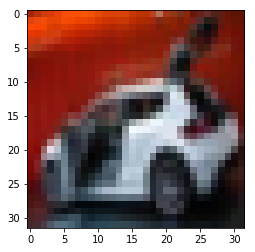

In [7]:
ind = 6
plt.imshow(imgs_raw[ind].astype(np.uint8),vmin=0,vmax=255,aspect='equal', interpolation='none') 
labelNames[lbls[ind]]

In [8]:
superClass = np.argmax(np.max(softmaxmat, axis=2),axis=1)
#print(np.max(softmaxmat,axis=1).shape)

In [9]:
cluster = []
for i in range(testSize):
    cluster.append(softmaxmat[i,superClass[i],:])
cluster = np.argmax(np.array(cluster),axis=1)

In [10]:
superClass[:100]

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0])

In [11]:
superlbls[lbls.flatten()==8]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [12]:
superlbls[:100]

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

In [13]:
classif = pd.DataFrame([classNames[superClass],cluster,range(testSize)],['superClass','cluster','index']).T
classifGrouped = classif.groupby(['superClass','cluster']).count()
classifGrouped

index
superClass cluster       
Animals    0          131
           1          138
           2          135
           3          125
           4          159
           5          143
Manmade    0          138
           1          149
           2          169
           3          153

In [14]:
#plot 5 images of each cluster in class c:
c='Manmade'
c='Animals'

In [15]:
t=[classif[(classif['superClass']==c) & (classif['cluster']==i)]['index'] for i in range(clustCount)]

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


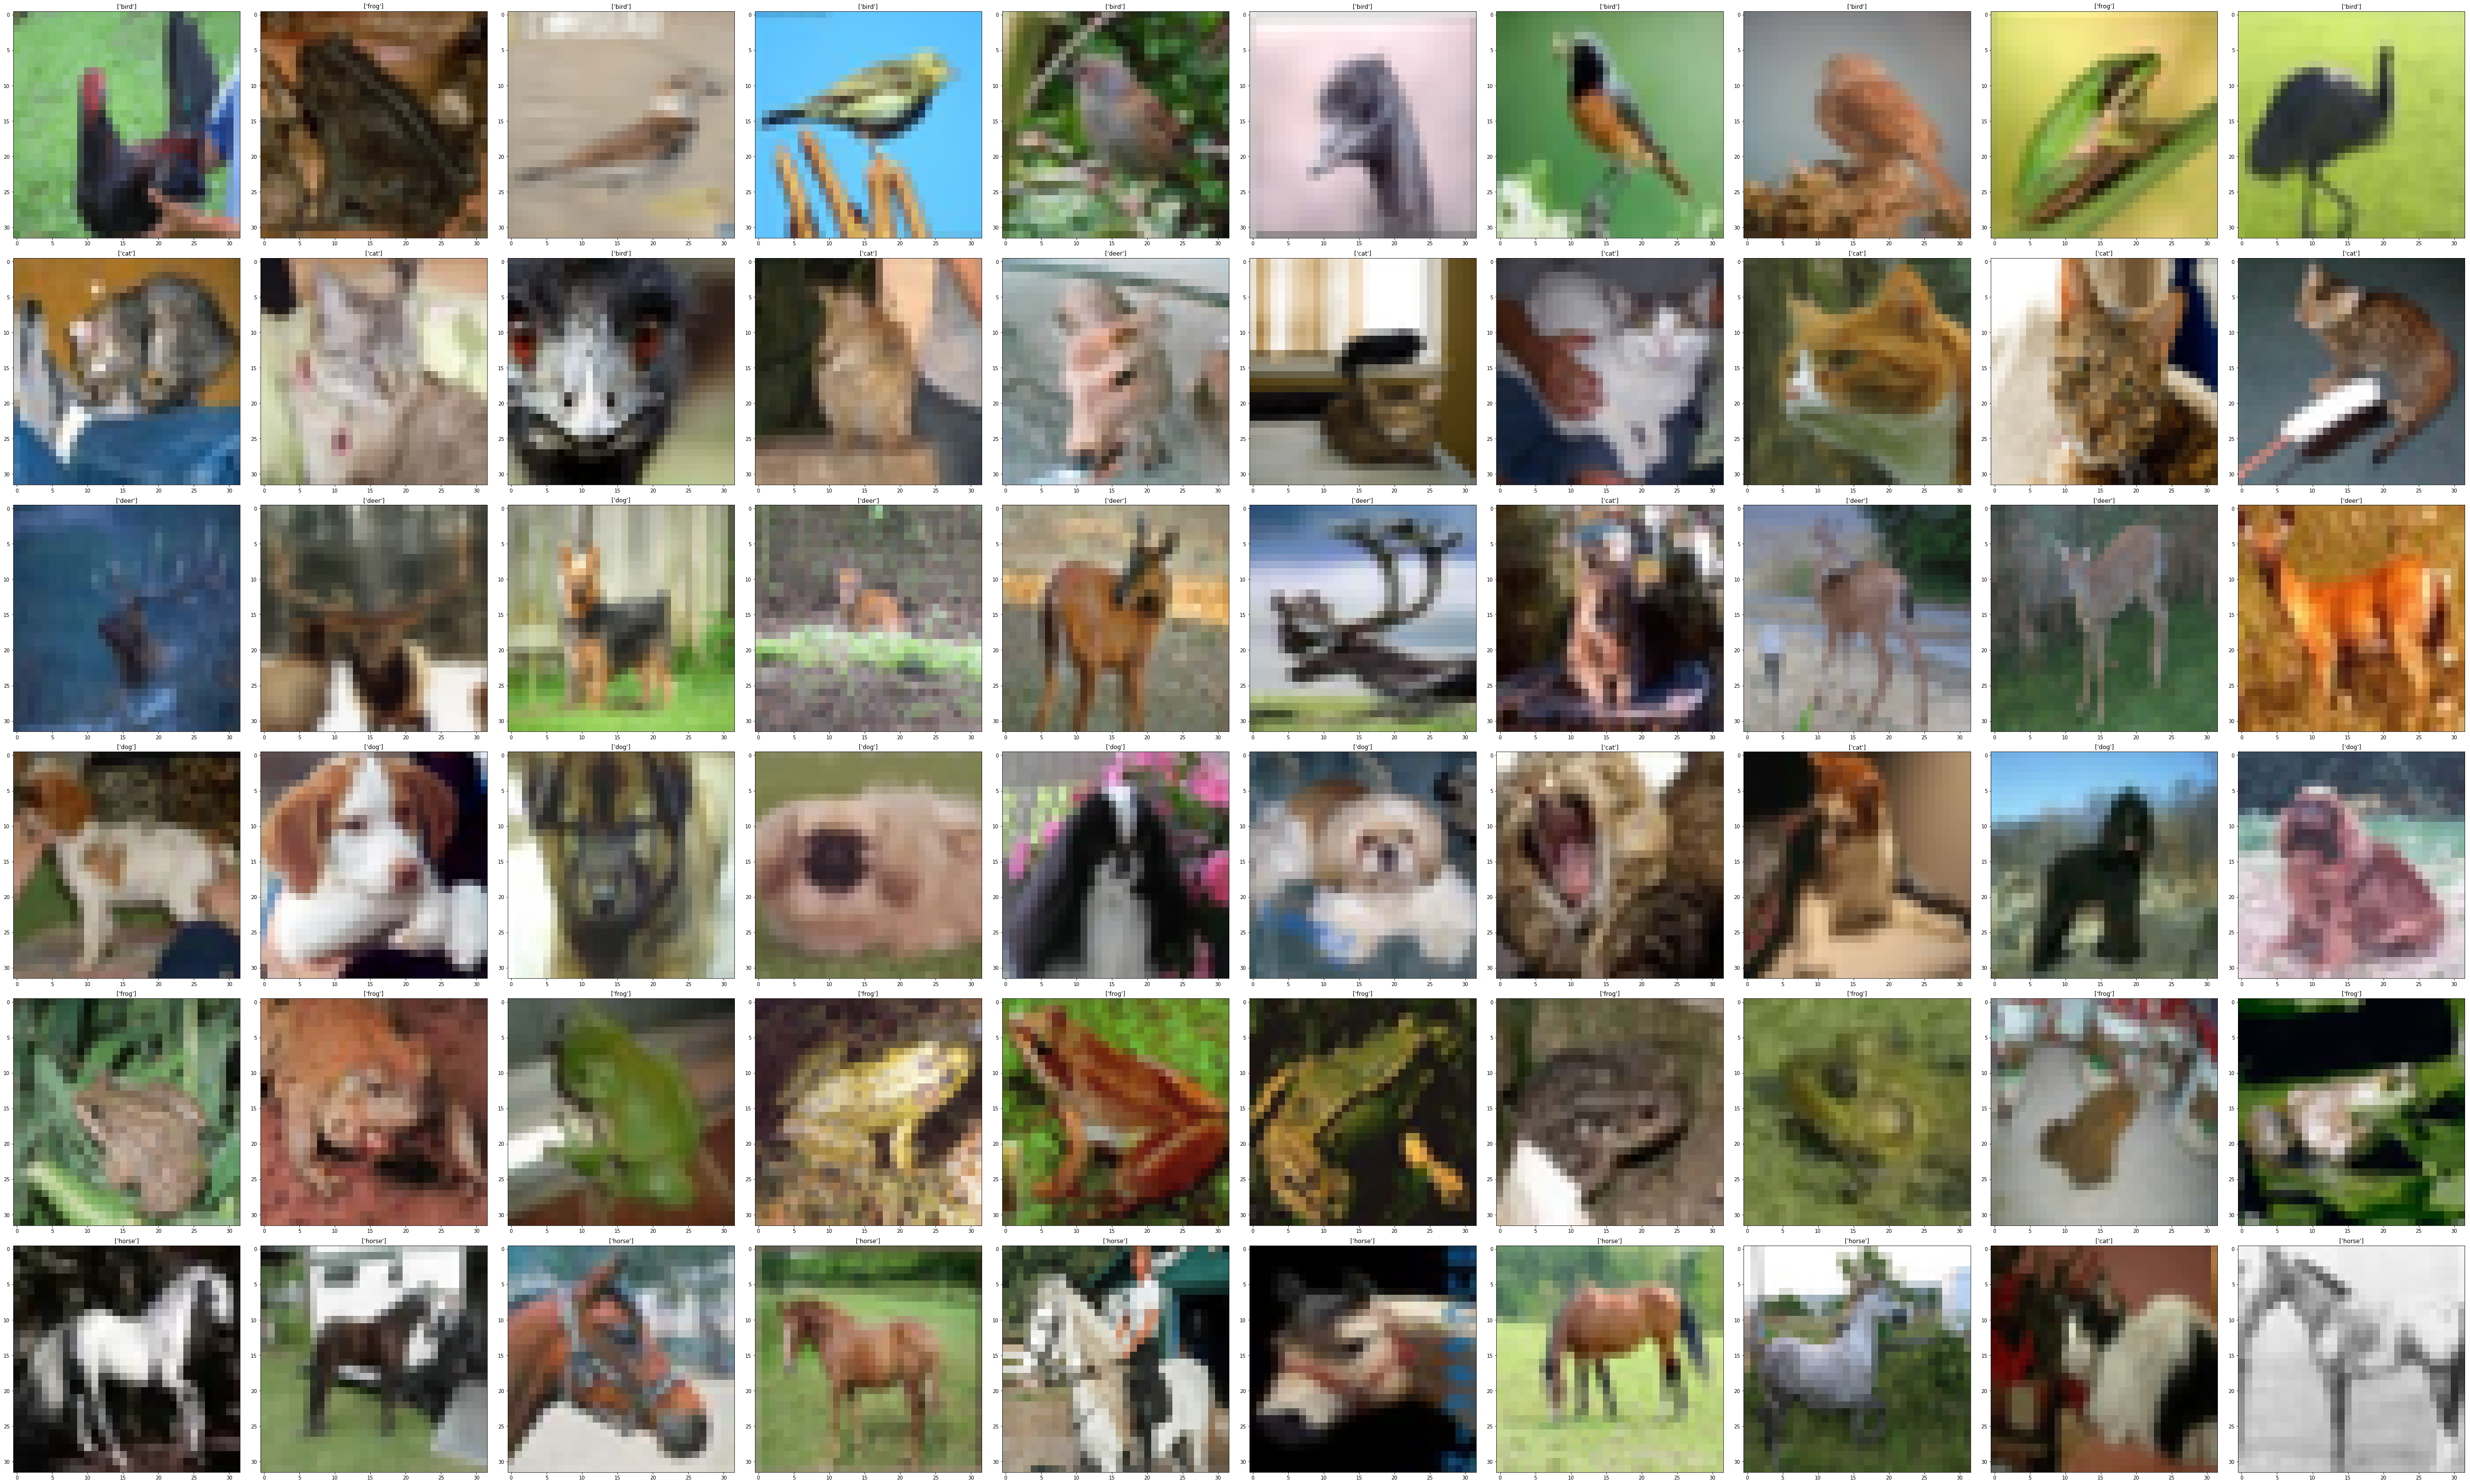

In [16]:
imCount=10
f, plots = plt.subplots(len(t),imCount)
f.set_figwidth(10*7)
f.set_figheight(clustCount*7)
plt.tight_layout()
for clust in range(len(t)):
    for index in range(imCount):
        if index < len(t[clust]):
            plots[clust,index].set_title(labelNames[lbls[t[clust].iloc[index]]])
            if len(imgs_raw[t[clust]].shape)>3:
                plots[clust,index].imshow(imgs_raw[t[clust]][index,:,:,:].astype(np.uint8),vmin=0,vmax=255,aspect='equal', interpolation='none')
            else:
                plots[clust,index].imshow(imgs_raw[t[clust]][:,:,:].astype(np.uint8),vmin=0,vmax=255,aspect='equal', interpolation='none')

## Performance scores

In [17]:
ypred = softmaxmat
onehotLabels = np.zeros((len(lbls),np.max(lbls)+1))
onehotLabels[np.arange(len(lbls)),lbls.T] = 1 #NOTE lbls.T voor PL
ypred = ypred.reshape((testSize,clustCount*classCount))
#print(np.argmax(ypred,1))
ypred = np.argmax(ypred,1)
print(np.sum(onehotLabels[ypred==0],0))
ylookup = np.argmax([np.sum(onehotLabels[ypred==i],0) for i in range(clustCount*classCount)],1)
yconverted = [ylookup[i] for i in ypred]
correct_prediction = np.equal(yconverted, lbls.T[0]) #NOTE lbls.T voor PL
clustAcc = np.mean(correct_prediction)
print('Clustering Accuracy: %g'%(clustAcc))
print(np.reshape(ylookup,(classCount,clustCount)))

[ 115.    2.    7.    4.    1.    0.    0.    2.    4.    3.]
Clustering Accuracy: 0.849306
[[0 1 8 9 0 0]
 [2 3 4 5 6 7]]


In [18]:
clustcls = np.array(zip(ypred,lbls))
counts = [np.bincount(clustcls[:,1][clustcls[:,0]==i]) for i in range(clustCount*classCount)]
#Per clust "accuracy":
clustAcc = [[np.max(c)/np.sum(c),np.sum(c),labelNames[np.argmax(c)]] if len(c)>0 else 0 for c in counts]
print('Manmade')
clustAcc[:clustCount]

Manmade


[[0.83333333333333337, 138, 'airplane'],
 [0.93288590604026844, 149, 'automobile'],
 [0.89349112426035504, 169, 'ship'],
 [0.92156862745098034, 153, 'truck'],
 0,
 0]

In [19]:
print('Animals')
clustAcc[clustCount:]

Animals


[[0.80152671755725191, 131, 'bird'],
 [0.73188405797101452, 138, 'cat'],
 [0.84444444444444444, 135, 'deer'],
 [0.73599999999999999, 125, 'dog'],
 [0.90566037735849059, 159, 'frog'],
 [0.84615384615384615, 143, 'horse']]

In [20]:
pur = np.sum([np.max(c) if len(c)>0 else 0 for c in counts])/testSize
print("Purity of clustering: %g"%pur)

Purity of clustering: 0.849306


In [21]:
superypred = np.argmax(np.max(softmaxmat,2),1)
correct_prediction = np.equal(superypred, superlbls)
print(superypred)
print(superlbls)
acc = np.mean(correct_prediction)
print('Superclass Accuracy: %g'%(acc))

[1 0 0 ..., 1 1 0]
[1 0 0 ..., 1 1 0]
Superclass Accuracy: 0.980556


# TODO
Why do my images look botched?
- Because they are floats, which imshow doesn't like, so it takes only the decimal bit and uses that

In [ ]:
#TSNE raw CIFAR
from sklearn.manifold import TSNE
model = TSNE(verbose=2)
#print(tf.reshape(imgs_raw,[imgs_raw.shape[0],-1]).shape)
tsned = model.fit_transform(np.reshape(imgs_raw,[imgs_raw.shape[0],-1]))

In [ ]:
#print(tsned.shape)
plt.figure(figsize=[50,50])
for im in range(imgs_raw.shape[0]):
    plt.imshow(imgs_raw[im].astype(np.uint8),vmin=0,vmax=255,aspect='equal', interpolation='none',extent=[tsned[im,0]-1,tsned[im,0]+1,tsned[im,1]-1,tsned[im,1]+1])
plt.scatter(tsned[:,0],tsned[:,1])

In [ ]:
plt.figure(figsize=[10,10])
for i in np.unique(lbls):
    plt.scatter(tsned[[lbls==i]][:,0],tsned[[lbls==i]][:,1],cmap='viridis',label=labelNames[i])
plt.legend()